In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import cm
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBClassifier,XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
import shap

from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

# for dirname, _, filenames in os.walk('/kaggle/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

# time series cross validation
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

''' FUNCTIONS '''

# One plot type
def plot_line(ldf,lst,title='',sec_id=None,size=[350,1000]):
    
    # sec_id - list of [False,False,True] values of when to activate supblots; same length as lst
    
    if(sec_id is not None):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure()
        
    if(len(lst) is not 1):
        ii=-1
        for i in lst:
            ii+=1
            if(sec_id is not None):
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)),secondary_y=sec_id[ii])
            else:
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)))
    else:
        fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[0]],mode='lines',name=lst[0],line=dict(width=2.0)))

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()
    
# plot n verticle subplots
def plot_vsubplots(ldf,lst,title='',nplots=None,lw_id=None,size=[400,1000]):

    # lw_id list of line widths if added
        
    assert(nplots is not None) 
    fig = make_subplots(rows=nplots,shared_xaxes=True)
    ii=-1
    for i in lst:
        ii+=1
        fig.add_trace(go.Scatter(x=ldf.index,y=ldf[lst[ii]], mode='lines',name=lst[ii],line=dict(width=lw_id[ii])), row=ii+1, col=1) 

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()
    
colours = ['tab:blue','tab:red','tab:green']
def plot_line2(ldf,lst,title=''):
    
    ii=-1
    plt.figure(figsize=(14,5))
    for i in lst:
        ii+=1
        ax = ldf[lst[ii]].plot(color=colours[ii],label=lst[ii],lw=1.5)
    plt.title(title)
    plt.legend();plt.show()
    
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    
    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0, 
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')
    
    if(ret_id):
        return corr
    
def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None, 
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None, 
             figsize = (10,4),axis_grid = 'y'):
        
    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)    
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

# function to plot a two PCA Feature Plot using Pandas 
def scatterPlot(xDF, yDF, algoName):
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["Component 1","Component 2","Label"]
    g = sns.scatterplot(x="Component 1",y="Component 2",data=tempDF,hue="Label",
                        linewidth=0.5,alpha=0.5,s=15,edgecolor='k')
    plt.title(algoName);plt.legend()
    
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
    ax.grid(axis = 'both',ls='--',alpha = 0.9)
    plt.show()
    
    
# reduce memory (@mfjwr1); distorts the data a little (but reduces by 60% memory)
def red_mem(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Split for TimeSeries
def TimeSeries_Split(ldf,
                     split_id=[None,None],
                     test_id=False,
                     cut_id=None):
    
    # Reduce the number of used data
    if(cut_id is not None):
        print('Reducing Input Data')
        
        if(type(cut_id) is int):
            ldf = ldf.iloc[-cut_id:]
        else:
            # input anything other than int
            print('Slicing based on period')
            ldf = ldf[data_period]
            
        t1 = ldf.index.max();t0 = ldf.index.min()
        print(f'Dataset Min.Index: {t0} | Max.Index: {t1}')
        
    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,pred_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split 
        train_df = df.loc[:split_id[1]]; pred_df = df.loc[split_id[1]:] 
    else:
        print('Choose One Splitting Method Only')
        
#     y_train = train_df[feature]
#     X_train = train_df.loc[:, train_df.columns != feature]
#     if(test_id):
#         y_test = pred_df[feature]
#         X_test = pred_df.loc[:, pred_df.columns != feature]
        
    return train_df,pred_df # return 

![](https://i.imgur.com/j5CTpDr.png)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>FOREWORD</span></b></p></div>

- Recently (2020 alone), a digital asset **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Bitcoin</mark>** has increased over 200% in value alone, having reached new heights, after which it dropped back down again
- This shows how **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">volatile</mark>** this asset is, which makes it one of the more interesting time series to explore, as opposed to standard stocks
- It's quite interesting to see how this **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">digital asset</mark>** has resurged in value after a recent dip, especially in the current financial climate
- There are quite a number of factors that can affect the asset, and we'll only be looking at traditional stock based factors
- This notebook is written for my own time series problem practice & coding of generic functions/classes and nothing more, the relevant dataset is used because of the extensive data availability of a highly volitile asset

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>DIGITAL ASSETS</span></b></p></div>

Snipplet from **[Dataset Description](https://www.kaggle.com/mczielinski/bitcoin-historical-data)**

> Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow. Included here is historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place. Happy (data) mining! 

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>STOCK PRICE INFLUENCES</span></b></p></div>

Features that can be useful for **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">stock price</mark>** prediction as outlined by <b>Tatsat et al (2020)</b>

##### **CORRELATED ASSETS**

> An organization depends on and interacts with many external factors, including its competitors, clients, the global economy, the geopolitical situation, fiscal and monetary policies, access to capital, and so on. Hence, its stock price may be correlated not only with the stock price of other companies but also with other assets such as commodities, FX, broad-based indices, or even fixed income securities.

##### **TECHNICAL INDICATORS**

> A lot of investors follow technical indicators. Moving average, exponential moving average, and momentum are the most popular indicators. 

##### **TECHNICAL REPORTS**

> Annual and quarterly reports of companies can be used to extract or determine key metrics, such as ROE (Return on Equity) and P/E (Price-toEarnings).

##### **NEWS REPORTS**

> News can indicate upcoming events that can potentially move the stock price in a certain direction.

- When focusing on **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">stock price</mark>**, one can utilise a few approaches when it comes to feature building/assembly (factors that affect the predicted variable) as shown above
- As indicated by **([source](https://cryptobriefing.com/is-bitcoin-stock-commodity/))**, <code>Bitcoin</code> is more of a **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">digital asset</mark>**, than a **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">stock</mark>** or a **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">currency</mark>**, thus it's not quite certain whether factors outlined are completely relevant to analyses involving <code>Bitcoins</code>
- However, **([source](https://www.mycryptopedia.com/best-8-bitcoin-indicators-for-cryptocurrency-trading/))** does outline various <code>indicators</code> that are useful specifically for <code>Bitcoin</code>price directivity prediction, which is a reasurence that **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">technical indicators</mark>** play and important role in <code>Bitcoin</code> time-series as well

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>PROBLEM DEFINITION</span></b></p></div>

- A major drawback of crypocurrency trading is the **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">volatility</mark>** of the market.
- The currency trades can occur 24/7 & tracking crypto position can be an impossible task to manage without automation.
- Automated Machine Learning trading algorithms can assist in managing this task, in order to predict the market's movement.
- We can use models to classify future movements into three categries: 

> <code>(1) The market will rise (take long position)</code>, <br>
> <code>(2) The market will fall (take short position)</code> <br>
> <code>(3) The market will move sideways (take no position)</code>.
    
    
- The problem of predicting a buy (<code>value=1</code>) or sell (<code>value=0</code>) signal for a **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">trading strategy</mark>** is defined in the
classification framework. 
- The buy or sell signal are decided on the basis of a comparison of short term vs. long
term price & is defined in <code>Section 2.2</code>
- Data harvesting (just data collection here) & <code>feature engineering</code> are relevant factors in time series model improvement. 
- It's interesting to investigate whether traditionally stock orientated feature engineering modifications are relevant to <code>digital assets</code>, and if so which ones
- Last but not least, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">model generation efficiency</mark>** becomes much more significant when dealing with **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">High Frequency Tick Data</mark>** as each added feature can have a substatial impact on the turnaround time of a model, due to the amount of data & balancing model accuracy & model output turnaround time is definitely worth managing

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>2 |</span></b> <b>THE DATASET</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>READING DATASET</span></b></p></div>

- Current dataset : CSV file for select bitcoin exchanges for the time period of Jan 2012 to September 2020, <code>1-min interval data</code> ([dataset](https://www.kaggle.com/mczielinski/bitcoin-historical-data))
- The feature <code>timestamp</code> can be parsed into a more conventional time index using the <code>pytz</code> library.
- The <code>Baseline Features</code> include: the asset's minute's <code>open</code>,<code>high</code>,<code>low</code>,<code>close</code>,<code>Volume_(BTC)</code>,<code>Volume_(Currency)</code> & <code>Weighted_Price</code>
- The loaded dataset, contains a specific start and end time index, in order to use models on unseen data, we need to split the dataset and not inspect it, the code used is hidden below.

In [2]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

# Data Periods used in Notebook
plot_period = slice('2020-7-7 0:00','2020-7-7 8:00') # Selectio Plot Period for visualisation only
data_period = slice('2020-7-6 13:21','2020-9-14 0:00') # Select Data Period for Analysis

# Path to CSV
path = '/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

In [3]:
# path = 'bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv'
df = pd.read_csv(path,parse_dates=[0],
                 date_parser=dateparse,
                 index_col='Timestamp')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4857377 entries, 2011-12-31 07:52:00+00:00 to 2021-03-31 00:00:00+00:00
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 296.5 MB


In [4]:
# It's possible to reduce the dataframe memory by 62% (if you need)
# red_df = red_mem(df)

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>WORKING WITH A SUBSET OF DATA</span></b></p></div>

- Due to the excess ammount of index data available to us, training of models can become quite long, especialy when it comes to cross validaiton.
- Let's limit the dataset to <code>100,000</code> (compared to 4.5M) recent data points in this notebook, which are assumed to be the most relevant to what we want to predict (future events)
- A <code>training data</code> period of only two months may not be sufficient to obtain a very accurate model (it's a short period of time, but contains quite a lot of data, nevertheless some trends may be missed), so you could try using even more points, if you have a more powerful PC.
- Some interesting applications to deal with larger datasets are of course <code>GPU</code> capable models which you could try.
- A very simple and easy to graps to use <code>XGBoost</code>'s GPU capable model example is provided by [hamditarek](https://www.kaggle.com/hamditarek/market-prediction-xgboost-with-gpu-fit-in-1min?q=XGboost+GPU).

In [5]:
df_tr,df_te = TimeSeries_Split(df,split_id=[0.2,None], #  Train/Test Split (0.8/0.2)
                               cut_id=data_period)     # Use only 100,000 data points 

Reducing Input Data
Slicing based on period
Dataset Min.Index: 2020-07-06 13:21:00+00:00 | Max.Index: 2020-09-14 00:00:00+00:00


<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>CLEANING DATA</span></b></p></div>

- The missing data is visualised and is shown to be consisten amongst features.
- Fill the data of indices during which there were no trades occuring, single-event. <code>value=0</code> (<b>Ignored</b>)
- Modify features <code>open</code>,<code>high</code>,<code>low</code>,<code>close</code> as the time series is continuous, using forward filling, <code>ffil</code>

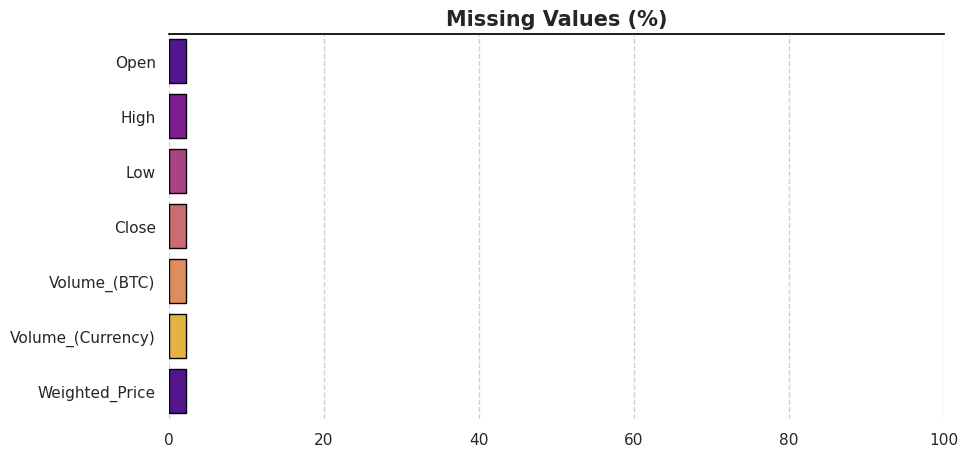

In [6]:
NaN_values = (df_tr.isnull().sum()/len(df_tr)*100).sort_values(ascending = False)

# Plot missing data
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index, 
         xlim = (0,100),xticklabels = range(0,101,20),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

In [7]:
df_tr[df_tr.isna().any(axis=1)]

Open  High  Low  Close  Volume_(BTC)  \
Timestamp                                                         
2020-07-06 14:21:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 15:07:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 18:10:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 21:12:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 21:17:00+00:00   NaN   NaN  NaN    NaN           NaN   
...                         ...   ...  ...    ...           ...   
2020-08-30 12:45:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-30 14:14:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-30 14:18:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-30 16:00:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-31 01:00:00+00:00   NaN   NaN  NaN    NaN           NaN   

                           Volume_(Currency)  Weighted_Price  
Timestamp                                                     
2020-07-06 14:21:00+00:00                NaN             NaN  
2020-07-06 15:07:00+00:00                NaN             NaN  
2020-07-06 18:10:00+00:00                NaN             NaN  
2020-07-06 21:12:00+00:00                NaN             NaN  
2020-07-06 21:17:00+00:00                NaN             NaN  
...                                      ...             ...  
2020-08-30 12:45:00+00:00                NaN             NaN  
2020-08-30 14:14:00+00:00                NaN             NaN  
2020-08-30 14:18:00+00:00                NaN             NaN  
2020-08-30 16:00:00+00:00                NaN             NaN  
2020-08-31 01:00:00+00:00                NaN             NaN  

[1749 rows x 7 columns]

Prediction with non events <code>.fillna(0)</code> can be interesting to include in signal modelling, but excluded here to have a more visible stock fluctuation history.

In [8]:
def forward_fill_na(ldf):
    # ldf['Volume_(BTC)'].fillna(0, inplace=True)
    # ldf['Volume_(Currency)'].fillna(0, inplace=True)
    # ldf['Weighted_Price'].fillna(0, inplace=True)
    ldf['Open'].fillna(method='ffill', inplace=True)
    ldf['High'].fillna(method='ffill', inplace=True)
    ldf['Low'].fillna(method='ffill', inplace=True)
    ldf['Close'].fillna(method='ffill', inplace=True)
    
forward_fill_na(df_tr)  # modification of training set
forward_fill_na(df_te) # modification of test set

In [9]:
#df = df.drop_duplicates(keep=False,inplace=True) 
df_tr = df_tr.dropna() 
df_te = df_te.dropna()     # replicate on test set

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>3 |</span></b> <b>EXPLORING OUR DATA</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>DESCRIPTIVE STATISTICS</span></b></p></div>

Let's investigate the statistics of the numerical values of the dataset

In [10]:
set_option('precision',2)
df_tr.describe()

Open      High       Low     Close  Volume_(BTC)  \
count  78251.00  78251.00  78251.00  78251.00      7.83e+04   
mean   10737.95  10742.28  10734.32  10738.30      4.66e+00   
std     1107.50   1108.95   1106.39   1107.59      1.33e+01   
min     9035.76   9041.22   9026.51   9040.00      2.00e-05   
25%     9351.95   9354.58   9350.35   9352.51      2.02e-01   
50%    11290.00  11296.53  11285.16  11290.15      1.17e+00   
75%    11679.83  11684.51  11675.60  11679.93      4.16e+00   
max    12450.91  12473.00  12436.31  12461.68      6.64e+02   

       Volume_(Currency)  Weighted_Price  
count           7.83e+04        78251.00  
mean            5.07e+04        10738.77  
std             1.45e+05         1107.77  
min             1.90e-01         9035.11  
25%             2.15e+03         9352.23  
50%             1.26e+04        11291.36  
75%             4.51e+04        11680.36  
max             7.94e+06        12457.50

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>TARGET VARIABLE</span></b></p></div>

- We need to define our prediction variable <code>signal</code>, which will be done via <code>.rolling</code> & <code>.mean()</code> using the <code>Close</code> feature.
- A short term (window) moving average, <code>SMA1</code> & a long term (window) moving average, <code>SMA2</code> are used to create the target variable, <code>signal</code>.
- The trading stratergy is as follows; where the <code>Short Term (SMA1)</code> > <code>Long Term (SMA2)</code>, the signal value = 1 <code>(buy)</code>, otherwise it is set to 0 <code>(sell)</code>.
- The <code>Short Term (SMA1)</code> & <code>Long Term (SMA2)</code> Moving Average value are set to <b>window values of 10 and 60</b> respectively, both of which are arbitrary, and can affect the results, ideally an optimisation study needs to be carried out to find optimum values.

In [11]:
def create_target(ldf,tr_id=False):
    ldf['SMA1'] = ldf['Close'].rolling(window=10, min_periods=1, center=False).mean() #  short simple moving average window
    ldf['SMA2'] = ldf['Close'].rolling(window=60, min_periods=1, center=False).mean() #  long simple moving average window
    ldf['signal'] = np.where(ldf['SMA1'] > ldf['SMA2'], 1.0, 0.0) # Create signals
    if(tr_id is not True):
        display(ldf['signal'].value_counts())
    
df_tr1 = df_tr.copy()  # Save the Baseline Model Dataframe [Training Set]
df_te1 = df_te.copy() # Save the Baseline Model Dataframe [Test Set]
create_target(df_tr1)  # Add target variable to Training Set 
create_target(df_te1,tr_id=True)  # Add target variable to Test Set

1.0    40125
0.0    38126
Name: signal, dtype: int64

- We have a relatively even (buy/sell) (40k/38k) target variable <code>signal</code> distribution
- We don't really have to emphasise issues associated with <code>class imbalance</code> in this problem
- Simple metrics like <code>accuracy,recall,precision</code> might suffice as <code>classification</code> metrics, instead of detailed ROC & PR curves of classifier models

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>DATASET TIMESERIES VISUALISATION</span></b></p></div>

Let's visualise the overall asset price history during the <code>training data</code> period & the associated <code>signal</code> as well.

In [12]:
plot_vsubplots(df_tr1,['Close','signal'],
               title='Weighted Price & Signal Fluctional in Training Data',
               nplots=2,
               lw_id=[2,0.4],
               size=[500,1000])

- It's interesting to note the general upward trend of the <code>weighted</code> asset price, having gone up from 9.2k at the start of this period and reaching 11.73k only within a span of a couple of months
- Not quite easy to visualise it, but the signal (what we will be modelling) is also plotted , and we can observe how much the shorter and longer period MA interchange in this short time period alone

In [13]:
# Visualise Training Set Target Variable Related Features

lst_MAV = ['SMA1','SMA2','signal']
ldf = df_tr1.loc[plot_period,lst_MAV]
plot_line(ldf,lst_MAV,
          title='SM1, SMA2 & Signal created from Closing Price',
          sec_id=[False,False,True])  

We can see that there are quite a number of periods during which the shorter and longer moving average values interchange, even for only an <b>8 hour</b> period, during which the cost varied in the range of <code>9240:9400</code> during the observed period, which is indicative of a highly volatile asset.

In [14]:
df_tr1=df_tr1.drop(['SMA1','SMA2'], axis=1)
df_te1=df_te1.drop(['SMA1','SMA2'], axis=1)   # replicate on test data

### <b><span style='color:#CDE10F'> 3.1 |</span> Baseline Model Features</b> 

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>BASELINE FEATURE CORRELATION</span></b></p></div>

Let's define the term baseline; the feature that are available to use in the dataset ie. **open**, **close** etc
- The linear correlation values of our current features <code>open</code>,<code>high</code>,<code>low</code>,<code>close</code>,<code>volumes</code>,<code>weighted_price</code> to the target variable is very minimal
- which could suggest a number of things; <code>high nonlinearity</code>, <code>stable oscillation relative to stationary value</code> (circular scatter) or perhaps they are not the most ideal to model the target, <code>signal</code>, and can be improved, so attention shifts to <code>feature engineering</code>

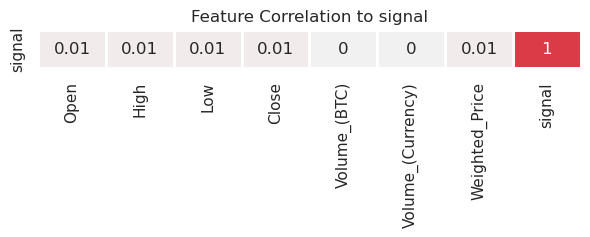

In [15]:
corrMat(df_tr1,'signal',figsize=(7,0.5)) # Baseline Dataframe feature correlation to Signal

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>FEATURE ENGINEERING</span></b></p></div>

- As indicated in the introduction, in the current problem, we will focus on <code>technical indicators</code> as part of our <code>feature engineering</code> approach in an attempt to introduce more relevant features into the <code>feature matrix</code>.
- It's interesting to know (in the context of a <code>digital asset</code> ), which features have impact on the model's performance, if any.

<b>Specifically:</b>

> - <code>Moving Average</code> : A moving average provides an indication of the trend of the price movement by reducing the amount of noise. <br>
> - <code>Stochastic Oscillator %K and %D</code> : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators. <br>
> - <code>Relative Strength Index(RSI)</code> : It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. Ranging from [0,100]. <b>Asset -> 70: asset deemed overbought</b>. <b>Asset -> 30: asset getting undersold & undervalued.</b><br>
> - <code>Rate Of Change(ROC)</code>: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. Assets with <b>higher ROC values</b> are considered more likely to be overbought & <b>lower ROC</b>; more likely to be oversold.<br>
> - <code>Momentum (MOM)</code> : It is the rate of acceleration of a security's price or volume; the speed at which the price is changing. <br>

Can be all be potentially useful to model the target variable, <code>signal</code>, with of course varing degress of influence.

In [16]:
df_tr2 = df_tr1.copy()  # Create duplicate dataframe & add features to it
df_te2 = df_tr2.copy()

In [17]:
''' Technical Indicators '''

#Calculation of moving average
def ma(df, n):
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))

# exponentially weighted moving average 
def ema(df, n):
    return pd.Series(df['Close'].ewm(span=n,min_periods=n).mean(), name='EMA_' + str(n))

#Calculation of price momentum
def mom(df, n):     
    return pd.Series(df.diff(n), name='Momentum_' + str(n))  

# rate of change
def roc(df, n):  
    M = df.diff(n - 1) ; N = df.shift(n - 1)  
    return pd.Series(((M / N) * 100), name = 'ROC_' + str(n)) 

# relative strength index
def rsi(df, period):
    delta = df.diff().dropna()
    u = delta * 0; d = u.copy()
    u[delta > 0] = delta[delta > 0]; d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# stochastic oscillators slow & fast
def sto(close, low, high, n,id): 
    stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    if(id is 0):
        return stok
    else:
        return stok.rolling(3).mean()

In [18]:
def tech_indi(ldf,tr_id=True):

    ''' Moving Average '''
    ldf['MA21'] = ma(ldf,10)
    ldf['MA63'] = ma(ldf, 30)
    ldf['MA252'] = ma(ldf, 200)
    lst_MA = ['MA21','MA63','MA252']

    ''' Exponentially Weighted Moving Average '''
    ldf['EMA10'] = ema(ldf, 10)
    ldf['EMA30'] = ema(ldf, 30)
    ldf['EMA200'] = ema(ldf, 200)
    lst_EMA = ['EMA10','EMA30','EMA200']

    ''' Momentum '''
    ldf['MOM10'] = mom(ldf['Close'], 10)
    ldf['MOM30'] = mom(ldf['Close'], 30)
    lst_MOM = ['MOM10','MOM30']

    ''' Relative Strength Index '''
    ldf['RSI10'] = rsi(ldf['Close'], 10)
    ldf['RSI30'] = rsi(ldf['Close'], 30)
    ldf['RSI200'] = rsi(ldf['Close'], 200)
    lst_RSI = ['RSI10','RSI30','RSI200']

    ''' Slow Stochastic Oscillators '''
    ldf['%K10'] = sto(ldf['Close'], ldf['Low'], ldf['High'],5,0)
    ldf['%K30'] = sto(ldf['Close'], ldf['Low'], ldf['High'],10,0)
    ldf['%K200'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 20,0)
    lst_pK = ['%K10','%K30','%K200']

    ''' Fast Stochastic Oscillators '''
    ldf['%D10'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 10,1)
    ldf['%D30'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 30,1)
    ldf['%D200'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 200,1)
    lst_pD = ['%D10','%D30','%D200']
    
    # Plot Training Data
    if(tr_id):
        plot_line(ldf.loc[plot_period,lst_MA],lst_MA,title='Moving Average (window=21,63,252)')
        plot_line(ldf.loc[plot_period,lst_EMA],lst_EMA,title='Exponential Moving Average (window=10,30,200)')
        plot_line(ldf.loc[plot_period,lst_MOM],lst_MOM,title='Momentum')
        plot_line(ldf.loc[plot_period,lst_RSI],lst_RSI,title='Relative Strength Index')
        plot_line(ldf.loc[plot_period,lst_pK],lst_pK,title='Stochastic Oscillators (slow)')
        plot_line(ldf.loc[plot_period,lst_pD],lst_pD,title='Stochastic Oscillators (Fast)')

In [19]:
tech_indi(df_tr2) # add technical features to training set
tech_indi(df_te2,tr_id=False) # add technical features to test set

In [20]:
# All the current features
df_tr2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'signal', 'MA21', 'MA63', 'MA252', 'EMA10', 'EMA30',
       'EMA200', 'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%K30',
       '%K200', '%D10', '%D30', '%D200'],
      dtype='object')

### <b><span style='color:#CDE10F'> 3.2 |</span> Updated Feature Model Features</b> 

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>UPDATED FEATURE LINEAR CORRELATION</span></b></p></div>

- Having created new features; <code>MA</code>,<code>EMA</code>,<code>MOM</code>,<code>RSI</code>,<code>%K/%D</code>,
- let's investigate the linear correlation of these new featuers to the target variable & compare to the <code>baseline dataset</code> features

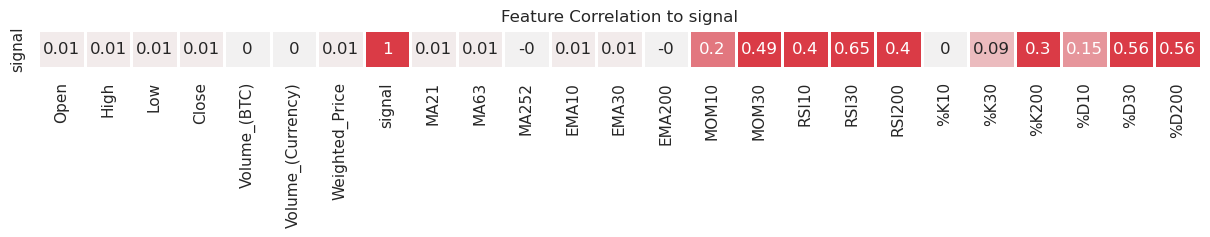

In [21]:
corrMat(df_tr2,'signal',figsize=(15,0.5))

- We can see the significanly more linearly correlated group of features that were created as a result of <code>feature engineering</code>
- It's likely that the <code>base</code> dataset features will have little to no impact on target variable variation if used in the <code>feature matrix</code>
- On the otherhand, the newly created features have a reasonably wide range of correlated values, and quite important; are not too highly correlated to the target variable, <code>signal</code>

In [22]:
def drp_feat(ldf):
    ldf = ldf.drop(['High','Low','Open','Volume_(Currency)'], axis=1) # let's drop most of the original feature
    
drp_feat(df_tr2)
drp_feat(df_te2)

Having applied functions to our <code>feature matrix</code>, we need to recheck for missing data.

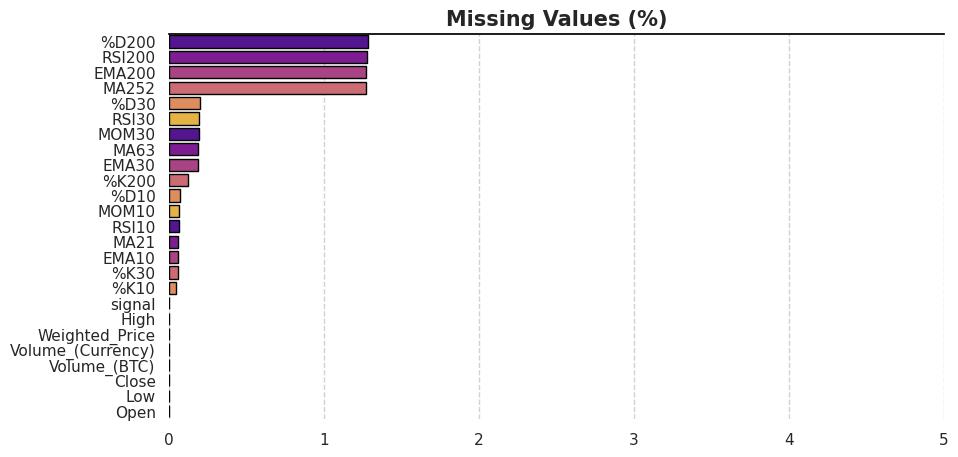

In [23]:
NaN_values = (df_tr2.isnull().sum() / len(df_tr2) * 100).sort_values(ascending = False)
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index, 
         xlim = (0,1),xticklabels = range(0,10),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

In [24]:
df_tr2 = df_tr2.dropna() 
df_te2 = df_te2.dropna()
df_tr2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78047 entries, 2020-07-06 16:44:00+00:00 to 2020-08-31 02:40:00+00:00
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               78047 non-null  float64
 1   High               78047 non-null  float64
 2   Low                78047 non-null  float64
 3   Close              78047 non-null  float64
 4   Volume_(BTC)       78047 non-null  float64
 5   Volume_(Currency)  78047 non-null  float64
 6   Weighted_Price     78047 non-null  float64
 7   signal             78047 non-null  float64
 8   MA21               78047 non-null  float64
 9   MA63               78047 non-null  float64
 10  MA252              78047 non-null  float64
 11  EMA10              78047 non-null  float64
 12  EMA30              78047 non-null  float64
 13  EMA200             78047 non-null  float64
 14  MOM10              78047 non-null  float64
 15  MOM30              7804

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>4 |</span></b> <b>MODEL GENERATION</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>EVALUATION FUNCTION</span></b></p></div>


Having defined a clear <code>target variable</code> & <code>feature matrix</code>, let's review what we have: <br><br>
- df_tr1/df_te1 : <code>Training/Test dataframe of baseline features associated to the asset</code>
- df_tr2/df_te2 : <code>Training/Test dataframe of newly created features created in feature engineering stage </code>

And we can start making models to predict the target variable <code>signal</code> (market directivity), using the evaluation function below.

<b>The Evaluation Function is (hidden below):</b><br><br>
The aim of the evaluation function is to evaluate how well the model performs on different data split & evaluation approaches.

<b>(1)</b> The function takes in a <code>dataframe</code> which contains both the <code>feature matrix, X</code> & <code>target variable, y</code>. <br>
<b>(2)</b> The data is split into two parts; <code>train_df</code> & <code>eval_df</code> <br>
<b>(3)</b> A 5-Fold <code>cross validation</code> evaluation of the imported dataframe is evaluated to get a picture of how well the model performs on the training data (both little and big chunks)<br>
<b>(4)</b> A standard Two-Way Split (without data shuffling) is made, and trained on <code>X_train/y_train</code> & <code>X_eval/y_eval</code>

In [25]:
models = []
# Lightweight Models 
models.append(('LDA', LinearDiscriminantAnalysis()))  # Unsupervised Model 
models.append(('KNN', KNeighborsClassifier()))  # Unsupervised Model
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('NB', GaussianNB())) # Unsupervised Model

# More Advanced Models
models.append(('GBM', GradientBoostingClassifier(n_estimators=25)))
models.append(('XGB',XGBClassifier(n_estimators=25,eval_metric='logloss')))
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))
models.append(('RF', RandomForestClassifier(n_estimators=25)))

In [26]:
# eval_id (T/F): [CV,Train,Test,all]

def modelEval(ldf,feature='signal',split_id=[None,None],eval_id=[True,True,True,True],
              n_fold=5,scoring='accuracy',plot_id=[False,True],cv_yrange=None,hm_vvals=[0.5,1.0,0.75]):
    
    print('Evaluation Function')
    print(f'Cross Validation Activated, n_splits : {n_fold}, scoring metric: {scoring}')
    if(eval_id[2]):
        if(split_id[0] is not None):
            print(f'Train/Evaluation Set Spit Activated: {split_id[0]}')
        if(split_id[1] is not None):
            print(f'Train/Evaluation Set Split made at {split_id[1]}')
    
    ''' 1. Split Train/Evaluation <DataFrame> Set Split '''
    
    # split_id : Train/Test split [%,timestamp], whichever is not None
    # test_id : Evaluate trained model on test set only
    
    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,eval_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split 
        train_df = df.loc[:split_id[1]]; eval_df = df.loc[split_id[1]:] 
    else:
        print('Choose One Splitting Method Only')
        
    ''' 2. Train/Test Feature Matrices + Target Variables Split'''
    
    y_train = train_df[feature]
    X_train = train_df.loc[:, train_df.columns != feature]
    y_eval = eval_df[feature]
    X_eval = eval_df.loc[:, eval_df.columns != feature]
    X_one = pd.concat([X_train,X_eval],axis=0)
    y_one = pd.concat([y_train,y_eval],axis=0)
    
    print('');print(f'Using Features: {X_train.columns}')
    print(f'Target Variable: {feature}');print('')
        
    ''' 3. Visualise Training/Test Data'''
    if(plot_id[0]):
        
        # plot the training data
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_df.index, y=train_df['signal'],mode='lines',name='Training Data', line={'width': 0.25}))
        fig.update_layout(height=300,width=800,template='plotly_white',title='Training Signal Visualisation',
                          margin=dict(l=50,r=80,t=50,b=40))
        
        # Plot the test data as well 
        if(eval_id[2]):
            fig.add_trace(go.Scatter(x=eval_df.index, y=eval_df['signal'],mode='lines',name='Test Data',line={'width': 0.25}))
            fig.update_layout(title='Training/Test Signal Visualisation')
        fig.show()
    
    ''' 4. Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)
            
            # Cross Validation Model on Training Se
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation
                
            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = accuracy_score(res.predict(X_train),y_train); lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = accuracy_score(res.predict(X_eval),y_eval); lst_eval.append(eval_res)
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction
            
            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = accuracy_score(res.predict(X_one),y_one); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe
            
            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")
      
    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
    s4 = pd.Series([tt1,tt2,tt3],index=['cv','train/test','all'])
        
    ''' 5. Visual Ouputs '''
    if(plot_id[1]): 
        
        sns.set(style="whitegrid")
        fig,ax = plt.subplots(1,2,figsize=(15,4))
        ax[0].set_title(f'{n_fold} Cross Validation Results')
        sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
        ax[0].set_xticklabels(names)
        sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3",linewidth=1)
        ax[0].set_xticklabels(names)
        ax[0].xaxis.grid(True)
        ax[0].set(xlabel="")
        if(cv_yrange is not None):
            ax[0].set_ylim(cv_yrange)
        sns.despine(trim=True, left=True)
    
        sns.heatmap(pdf,vmin=hm_vvals[0],vmax=hm_vvals[1],center=hm_vvals[2],
                    ax=ax[1],square=False,lw=2,annot=True,fmt='.3f',cmap='Blues')
        ax[1].set_title('Accuracy Scores')
        plt.show()

### <b><span style='color:#CDE10F'> 4.1 |</span> BASELINE FEATURE MODEL EVALUATION</b> 

- The **<span style='color:#CDE10F'>Baseline Features</span>** include:
> The asset's minute's <code>open</code>,<code>high</code>,<code>low</code>,<code>close</code>,<code>Volume_(BTC)</code>,<code>Volume_(Currency)</code> & <code>Weighted_Price</code>
- As I found out, in time series applications, it's not very common to use base features associated with one asset only, but let's see how it fairs anyway, let's also plot the training data to get a visual idea of what we are attempting to model.

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price'],
      dtype='object')
Target Variable: signal

LDA : 0.513(0.014) -> 0.62s | 0.522 & 0.513 -> 0.17s | 0.522 -> 0.18s
KNN : 0.501(0.003) -> 2.16s | 0.698 & 0.503 -> 2.29s | 0.698 -> 2.3s
TREE : 0.501(0.010) -> 5.15s | 1.000 & 0.511 -> 1.38s | 1.000 -> 1.6s
NB : 0.508(0.018) -> 0.10s | 0.516 & 0.503 -> 0.03s | 0.514 -> 0.033s
GBM : 0.508(0.019) -> 20.75s | 0.551 & 0.510 -> 5.25s | 0.541 -> 6.8s
XGB : 0.500(0.014) -> 6.93s | 0.627 & 0.519 -> 1.47s | 0.614 -> 1.8s
CAT : 0.498(0.015) -> 1.21s | 0.574 & 0.502 -> 0.26s | 0.570 -> 0.3s
RF : 0.502(0.014) -> 24.71s | 0.998 & 0.508 -> 6.67s | 0.998 -> 8.6s


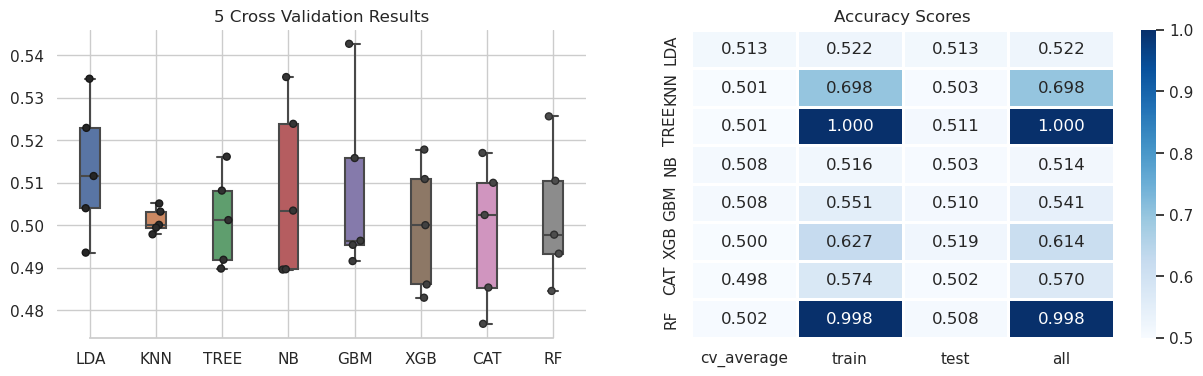

In [27]:
modelEval(df_tr1,split_id=[0.2,None],plot_id=[False,True])

- We can see that the **<span style='color:#CDE10F'>cross_val_score</span>** is hovering in the region of **<span style='color:#CDE10F'>accuracy = 0.5</span>**, which suggests that using only **<span style='color:#CDE10F'>baseline features</span>** associated with one asset isn't quite suitable to predict accurate **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">asset directivity</mark>**
- Most models tended to have a higher **<span style='color:#CDE10F'>training score</span>** than the **<span style='color:#CDE10F'>cross validation score</span>**
- It was interesting to see that the **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">DecisionTreeClassifier</mark>** & **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">RandomForest</mark>**, even with very few estimators are able to achieve very high scores (be it overfitted)
- This suggests tree based models could be very useful in this problem & **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">kNN</mark>** can also be added to the list of someone overfitting models on the training data as they tend to have lower cross validation scores

**<span style='color:#CDE10F'>Training & Evaluation time</span>** also is quite important in this problem:
- Having used only (100k/4.5M), the cost even with 7 features is quite high for the more advanced models, (<code>esp.GBM & ANN</code>); 
- More advanced models had to be tuned down significantly to reduce the training time to comparable levels, therefore it's desirable to optimise the feature selection process.
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">XGB</mark>** & **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">CATBoost</mark>**, surprising were quite quick for quite advanced model, indicating it's quite well optimised for being used right out of the box. 
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">RandomForest</mark>** being a similar model to XGB is much slower.

### <b><span style='color:#CDE10F'> 4.2 |</span> Updated feature model evaluation</b> 

We created new features in the <code>feature engineering</code> in <code>Section 2.5</code>, generating the updated features: <code>df_feat</code> dataframe, let's retry with these new features. 

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'MA21', 'MA63', 'MA252', 'EMA10', 'EMA30', 'EMA200',
       'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%K30', '%K200',
       '%D10', '%D30', '%D200'],
      dtype='object')
Target Variable: signal

LDA : 0.906(0.017) -> 1.29s | 0.908 & 0.927 -> 0.32s | 0.910 -> 0.37s
KNN : 0.577(0.016) -> 60.71s | 0.783 & 0.640 -> 95.22s | 0.794 -> 1.1e+02s
TREE : 0.866(0.018) -> 9.85s | 1.000 & 0.894 -> 2.61s | 1.000 -> 3.3s
NB : 0.761(0.012) -> 0.15s | 0.762 & 0.789 -> 0.06s | 0.768 -> 0.063s
GBM : 0.893(0.006) -> 61.80s | 0.897 & 0.905 -> 15.76s | 0.900 -> 2e+01s
XGB : 0.919(0.007) -> 17.78s | 0.943 & 0.930 -> 4.30s | 0.941 -> 5.2s
CAT : 0.914(0.009) -> 2.47s | 0.925 & 0.930 -> 0.56s | 0.925 -> 0.64s
RF : 0.898(0.019) -> 28.88s | 1.000 & 0.920 -

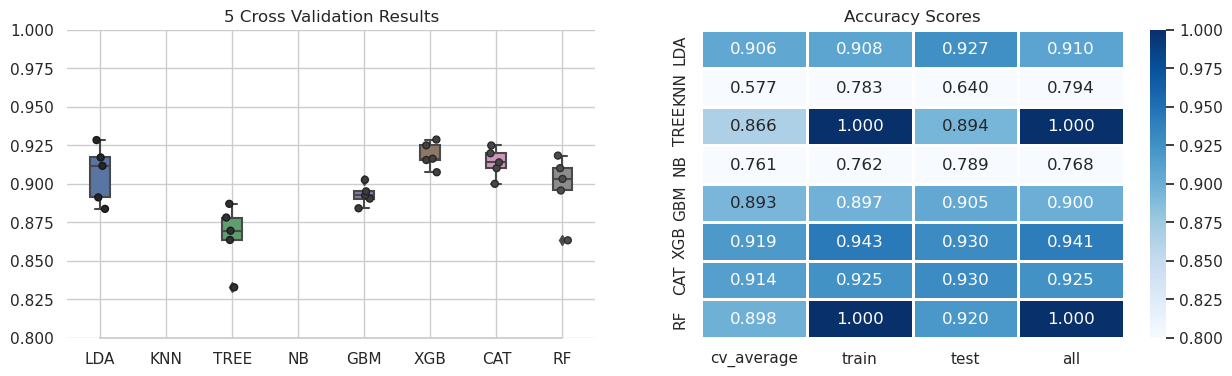

In [28]:
modelEval(df_tr2,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

- We can see a very significant improvement in the **<span style='color:#CDE10F'>accuracy</span>** scores, when compared to the **<span style='color:#CDE10F'>baseline model</span>**
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">LinearDiscriminantAnalysis()</mark>** performs surprising well, for not only on the training set but also in the cross validation, it's also one of the fastest approaches, making it one of the most efficient approaches for large datasets
- Among the higher scoring model **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">LDA</mark>**, are not surprisingly more advanced models, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">GBM</mark>**,**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">XGB</mark>**,**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">CAT</mark>**,**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">RF</mark>** as well
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">kNN()</mark>** and **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">GaussianNB()</mark>** unsupervised models performed slightly worse, in comparison to supervised learning models


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>5 |</span></b> <b>MODEL EFFICIENCY OPTIMISATION</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>UTILISING DIMENSIONALITY REDUCTION</span></b></p></div>


- A big issue encounted when trying to reach the objective in the problem is the large number of tick data (every minute) in the entire dataset, which increases the computational training & evaluation cost quite a bit.
- Since the **<span style='color:#CDE10F'>feature matrices</span>** are dependent on the number of features & instances, a reduction of even one unnecessary feature woud have a visible impact on the computational cost.
- It is therefore of upmost importance to <b>reduce unnecessary features</b> as much as possible, to the problem 
balancing act between model accuracy and training/prediction speed.

<b>Let's look at two approaches one might take:</b>

- <b>(1) Dimensionality Reduction via Feature Importance Evaluation (which is a more manual process) </b>

> Although this is more of a manual process since all libraries are not combine, let's try to find common ground between all approaches and combine them into one <code>feature importance</code> evaluation approach function to allow us to identify, evaluate and remove features to speed up our approach.

- <b>(2) Dimensionality Reduction using Unsupervised Learning Algorithms (more automated process)</b>

> A rather straightforward <code>fit & transform</code> collection of powerful <code>dimension reduction</code> algorithms are available to us in the <code>sklearn</code> library, the only issue I can think of is that; explaining what the resultant features mean may be a little problematic.

### <b><span style='color:#CDE10F'> 5.1 |</span> Dimensionality reduction via feature importance</b> 

- We can look at the <b>Feature Importance</b> (FI) of certain trained models to understand which features & to what extent.
- We can use such minimalistic functions to quicky evaluat feature importance by relying on <b>variation of approaches</b> & <b>optimised libraries</b>.
- We can obtain <b>relative feature importance</b> using different libraries , <b>function</b> <code>feature_importance</code> includes:

> - **<span style='color:#CDE10F'>Linear Correlation</span>** w/ abs() function.
> - **<span style='color:#CDE10F'>SHAP Values</span>** of Catboost Regression Model (n_est)
> - **<span style='color:#CDE10F'>RandomForest Regressor</span>** (n_est)
> - **<span style='color:#CDE10F'>XGBoost Regressor</span>** (n_est)
> - **<span style='color:#CDE10F'>CatBoost Regressor</span>** (n_est)
> - **<span style='color:#CDE10F'>SelectKBest</span>** (k)

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>ADDITIONAL ADJUSTMENTS</span></b></p></div>

- The indivual scores are combined and scaled using <code>MinMaxScaler()</code> & Plot.
- The y-axis represents the total score (higher score is better, max -> Number of approaches).
- The x-axis represents the corresponding features of input dataframe.

In [29]:
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBRegressor
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import shap
import seaborn as sns

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='signal',figsize=(9,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2)
    shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    
    if(ret_id):
        return corr

''' Feature Importance '''
# Various Approaches for quick FI evaluation

def fi(ldf,target='signal',n_est=25,num_only=True,
       drop_id=None,target_cat=True,drop_na=False):
    
    # Select only numerical features
    if(num_only):
        ldf = ldf.select_dtypes(include=['float64','int64'])    
    
    # Drop all NaN
    if(drop_na):
        print(f'Before NaN drop: {ldf.shape}')
        ldf = ldf.dropna()
        print(f'After NaN dropped: {ldf.shape}')
    
    
    ldf = ldf.copy()
    # If target is categorical string variable
    if(target_cat):
        cats = ldf[target].unique()
        cats_id = [i for i in range(0,len(cats))]
        maps = dict(zip(cats,cats_id))    
        ldf[target] = ldf[target].map(maps)
    
    # If any features are desired to be droped 
    if(drop_id is not None):
        ldf = ldf.drop(drop_id,axis=1)

    # Input dataframe containing feature & target variable
    y = ldf[target]
    X = ldf.drop(target,axis=1)
    
#   CORRELATION
    imp = corrMat(ldf,target,figsize=(15,0.5),ret_id=True)
    del imp[target]
    s1 = imp.squeeze(axis=0);s1 = abs(s1)
    s1.name = 'CORR'
    
#   SHAP
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    s2 = pd.Series(shap_sum,index=X.columns,name='CAT_SHAP').T
    
#   CATBOOST
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['CAT'])
    rf_fi.sort_values('CAT',ascending=False)
    s3 = rf_fi.T.squeeze(axis=0)
    
#   RANDOMFOREST
    model = RandomForestRegressor(n_est,random_state=0, n_jobs=-1)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['RF'])
    rf_fi.sort_values('RF',ascending=False)
    s4 = rf_fi.T.squeeze(axis=0)

#   XGB 
    model=XGBRegressor(n_estimators=n_est,learning_rate=0.5,verbosity = 0)
    model.fit(X,y)
    data = model.feature_importances_
    s5 = pd.Series(data,index=X.columns,name='XGB').T

#   KBEST
    model = SelectKBest(k=5, score_func=f_regression)
    fit = model.fit(X,y)
    data = fit.scores_
    s6 = pd.Series(data,index=X.columns,name='KBEST')

    # Combine Scores
    df0 = pd.concat([s1,s2,s3,s4,s5,s6],axis=1)
    df0.rename(columns={'target':'lin corr'})

    # MinMax Scaler
    x = df0.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled,index=df0.index,columns=df0.columns)
    df = df.rename_axis(f'<b>FI APPROACH</b>', axis=1)
    df = df.rename_axis('Feature', axis=0)
    
    pd.options.plotting.backend = "plotly"
    fig = df.plot(kind='bar',title='<b>SCALED FEATURE IMPORTANCE</b>',
                  color_discrete_sequence=px.colors.qualitative.T10)
    fig.update_layout(template='plotly_white',height=400,
                     font=dict(family='sans-serif',size=12),
                     margin=dict(l=60, r=40, t=50, b=10))
    fig.update_traces(width=0.25)
    fig.show()

In [30]:
fi(df_tr2)

- We can note that for a lot of features, a small value in <code>correlation</code> magnitude (Pearson's value) also gives small score values in other approaches. Similarly high <code>correlated</code> features tend to have high scores in other <code>feature importance</code> methods, which is quite interesting. There are some exceptions, like <code>%D10</code> & <code>MOM10</code>
- Whilst there are a few features which show some slight dissagreement when it comes to feature importance, overall, <b>feature score similarity can be observed  for most approaches</b>
- It's interesting to note scores of identical feature cases (eg. <code>MOM10</code>, <code>MOM30</code>); we can get an idea of potentially new features that could we could try out ( perhaps <code>MOM20</code> would have worked better than <code>MOM10</code> )
- We can observe a lot of features that have a <b>very low relative score value</b> for most methods, and hence probably have little to no impact, even if they were to be removed
- Removing potentially unimpactful features (which is around 50% of them) would make our whole approach much more efficient, and allow us to focus on more lengthy and in depth <code>hyperparameter</code> gridsearches that hopefully will be more accurate than any of our current models

In [31]:
df_tr2_FI = df_tr2.drop(columns=['Open','High','Low','Close','Volume_(BTC)','Volume_(Currency)','Weighted_Price','MA63','EMA10','%K10'])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['MA21', 'MA252', 'EMA30', 'EMA200', 'MOM10', 'MOM30', 'RSI10', 'RSI30',
       'RSI200', '%K30', '%K200', '%D10', '%D30', '%D200'],
      dtype='object')
Target Variable: signal

LDA : 0.903(0.013) -> 0.84s | 0.904 & 0.923 -> 0.22s | 0.906 -> 0.25s
KNN : 0.769(0.037) -> 3.91s | 0.944 & 0.833 -> 5.12s | 0.944 -> 5.1s
TREE : 0.870(0.016) -> 5.73s | 1.000 & 0.894 -> 1.49s | 1.000 -> 1.9s
NB : 0.776(0.010) -> 0.12s | 0.776 & 0.797 -> 0.04s | 0.780 -> 0.046s
GBM : 0.893(0.005) -> 36.12s | 0.898 & 0.905 -> 9.17s | 0.900 -> 1.2e+01s
XGB : 0.917(0.007) -> 11.73s | 0.941 & 0.931 -> 2.73s | 0.942 -> 3.4s
CAT : 0.915(0.007) -> 1.48s | 0.922 & 0.927 -> 0.36s | 0.922 -> 0.41s
RF : 0.907(0.009) -> 21.19s | 1.000 & 0.923 -> 5.76s | 1.000 -> 7.6s


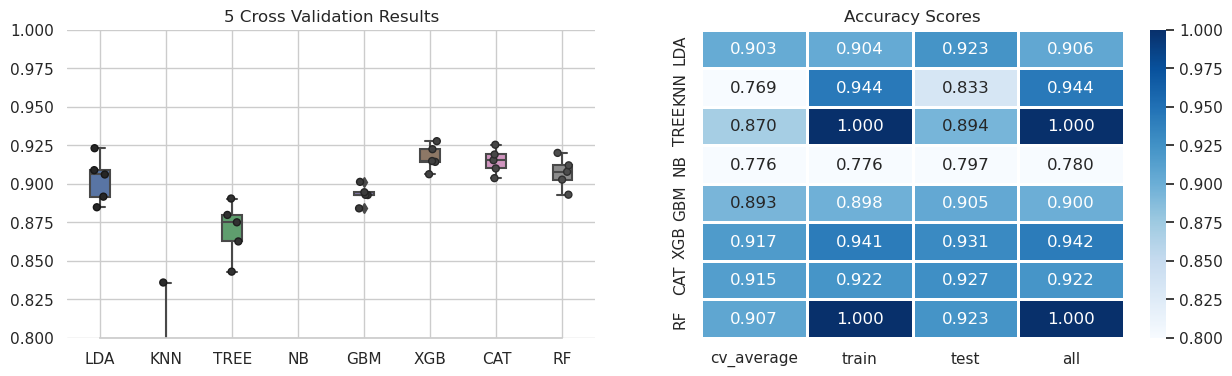

In [32]:
modelEval(df_tr2_FI,split_id=[0.2,None],plot_id=[False,True],cv_yrange=(0.8,1.0),hm_vvals=[0.8,1.0,0.9])

### <b><span style='color:#CDE10F'> 5.2 |</span> Dimensionality reduction using unsupervised learning algorithms</b> 

An alternative approach to **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">feature reduction</mark>** is the utilisation of **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Unsupervised Learning</mark>** methods.
- We need to select an algorithm (it's best to look at quite a few and see how they perform),
- Perhaps apply some **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">scaling</mark>** & simply <code>fit_transform</code> to get the modified <code>feature matrix</code> which will have the selected dimension

The next function contains the following selectable **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Unsupervised Learning</mark>** algorithms to achieve dimensionaliy reduction:
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Sparse PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Kernel PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Incremental PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Truncated SVD</mark>** 
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Fast ICA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Gaussian Random Projection</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Sparse Random Projection</mark>**
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">IsoMap</mark>** (Manifold),**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">MDS</mark>** (Manifold),**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">TSNE</mark>** (Manifold)
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Locally Linear Embedding</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Mini Batch Dictionary Learning</mark>**

- Not all of them are realisable on Kaggle due to the limited computational memory (esp. <b>Manifold</b> approaches), even with the <code>red_mem</code> function activated
- It's not too uncommon to use multi stage approaches for **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">manifold</mark>** methods, eg. a **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">PCA</mark>** step before **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">manifold</mark>** approach
- Here we'll use approaches that are requite less computational resources to run

In [33]:
def dimRed(ldf,feature='signal',split_id=[None,None],n_comp=5,plot_id=True,
           model_id='sparserandomprojection',scaler_id=[False,None]):
    
    # Given a dataframe, split feature/target variable
    X = ldf.copy()
    y = ldf[feature].copy()
    del X[feature]
    
    n_jobs = -1; rs = 32
    
    if(model_id is 'pca'):
        whiten = False
        model = PCA(n_components=n_comp,whiten=whiten,random_state=rs)
    if(model_id is 'sparsepca'):
        alpha = 1
        model = SparsePCA(n_components=n_comp,alpha=alpha,random_state=rs,n_jobs=n_jobs)
    elif(model_id is 'kernelpca'):
        kernel = 'rbf'; gamma = None
        model = KernelPCA(n_components=n_comp,kernel=kernel,gamma=gamma,n_jobs=n_jobs,random_state=rs)
    elif(model_id is 'incrementalpca'):
        batch_size = None
        model = IncrementalPCA(n_components=n_comp,batch_size=batch_size)
    elif(model_id is 'truncatedsvd'): 
        algorithm = 'randomized';n_iter = 5
        model = TruncatedSVD(n_components=n_comp,algorithm=algorithm,n_iter=n_iter,random_state=rs)
    elif(model_id is 'gaussianrandomprojection'):
        eps = 0.5
        model = GaussianRandomProjection(n_components=n_comp,eps=eps,random_state=rs)
    elif(model_id is 'sparserandomprojection'):
        density = 'auto'; eps = 0.5; dense_output = True
        model = SparseRandomProjection(n_components=n_comp,density=density, 
                                       eps=eps, dense_output=dense_output,random_state=rs)
    if(model_id is 'isomap'):
        n_neigh = 2
        model = Isomap(n_neighbors=n_neigh,n_components=n_comp, n_jobs=n_jobs)    
    elif(model_id is 'mds'):
        n_init = 1; max_iter = 50; metric = False
        model = MDS(n_components=n_comp,n_init=n_init,max_iter=max_iter,metric=True,
                    n_jobs=n_jobs, random_state=rs)
    elif(model_id is 'locallylinearembedding'):
        n_neigh = 10; method = 'modified'
        model = LocallyLinearEmbedding(n_neighbors=n_neigh,n_components=n_comp, method=method, \
                                    random_state=rs, n_jobs=n_jobs)
    elif(model_id is 'tsne'):
        learning_rate = 300; perplexity = 30; early_exaggeration = 12; init = 'random'
        model = TSNE(n_components=n_comp, learning_rate=learning_rate, \
                    perplexity=perplexity, early_exaggeration=early_exaggeration, \
                    init=init, random_state=rs)
    elif(model_id is 'minibatchdictionarylearning'):
        alpha = 1; batch_size = 200; n_iter = 25
        model = MiniBatchDictionaryLearning(n_components=n_comp,alpha=alpha,
                                            batch_size=batch_size,n_iter=n_iter,random_state=rs)
    elif(model_id is 'fastica'):
        algorithm = 'parallel'; whiten = True; max_iter = 100
        model = FastICA(n_components=n_comp, algorithm=algorithm,whiten=whiten, 
                          max_iter=max_iter, random_state=rs)
    
    # Scaling 
    if(scaler_id[0]):
        
        opts = [StandardScaler(),RobustScaler(),MinMaxScaler(), Normalizer(norm='l2')]
        scaler = opts[scaler_id[1]].fit(X) 
        X_sca = pd.DataFrame(scaler.fit_transform(X),
                                       columns = X.columns,
                                       index = X.index) # summarize transformed data 
    
    # Unsupervised Dimension Reduction 
    if(scaler_id[0]):
        X_red = model.fit_transform(X_sca)
    else:
        X_red = model.fit_transform(X)
    X_red = pd.DataFrame(data=X_red, index=X.index)
    if(plot_id):
        scatterPlot(X_red, y,model_id)
    X_red[feature] = y
    
    return X_red # return new feature matrix

- We use dimensionality reduction on <code>df_tr2</code>, before using the <code>modelEval</code> function as before, noting the accuracy & execution times
- For dimensionality reduction, we'll use **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Fast ICA</mark>** here together with different data **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">data scaling methods</mark>**, you can try different combinations, with the aim being to obtain as high accuracy as possible

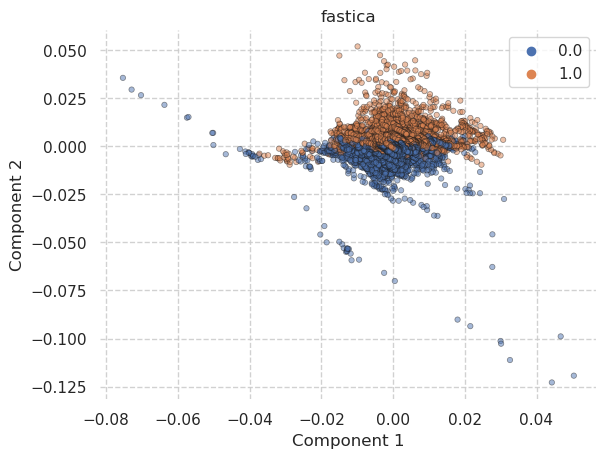

In [34]:
# Standard ICA (no scaling)
df_tr2_ICA = dimRed(df_tr2,
                    split_id=[0.2,None],
                    model_id='fastica',
                    n_comp=5)

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.829(0.009) -> 0.53s | 0.831 & 0.852 -> 0.15s | 0.836 -> 0.16s
KNN : 0.820(0.014) -> 3.05s | 0.886 & 0.822 -> 3.34s | 0.887 -> 3.4s
TREE : 0.778(0.025) -> 2.75s | 1.000 & 0.776 -> 0.75s | 1.000 -> 0.93s
NB : 0.821(0.021) -> 0.09s | 0.825 & 0.845 -> 0.03s | 0.833 -> 0.031s
GBM : 0.834(0.022) -> 13.87s | 0.841 & 0.861 -> 3.58s | 0.844 -> 4.6s
XGB : 0.840(0.017) -> 7.10s | 0.861 & 0.853 -> 1.54s | 0.862 -> 1.9s
CAT : 0.840(0.016) -> 1.08s | 0.850 & 0.854 -> 0.26s | 0.853 -> 0.3s
RF : 0.830(0.020) -> 17.74s | 0.998 & 0.839 -> 4.98s | 0.998 -> 6.5s


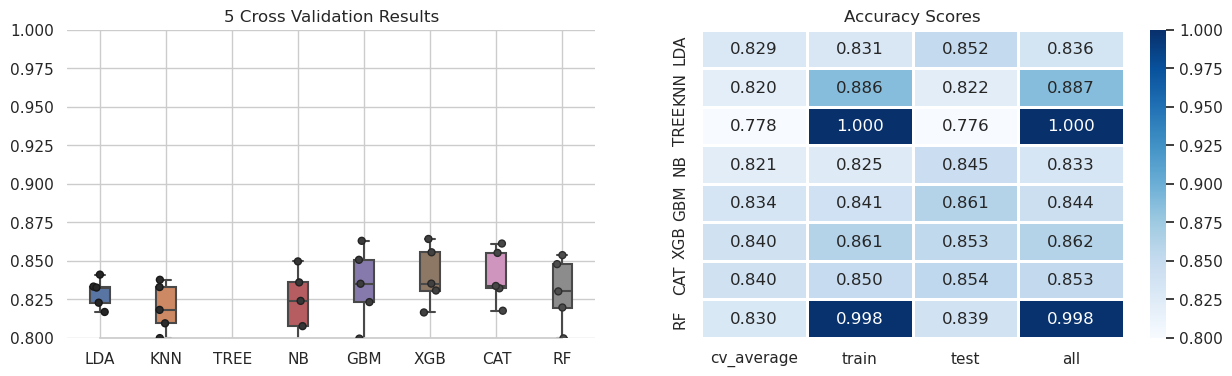

In [35]:
modelEval(df_tr2_ICA,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

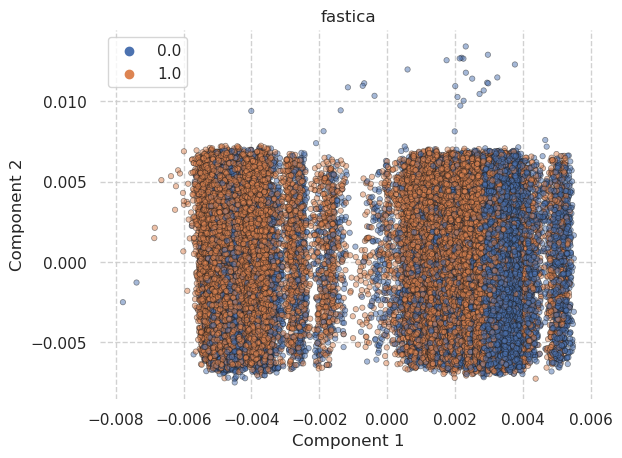

In [36]:
'''StandardScaler ICA'''
df_tr2_ICA_sca0 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,0])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.828(0.012) -> 0.53s | 0.829 & 0.843 -> 0.15s | 0.835 -> 0.16s
KNN : 0.823(0.010) -> 3.06s | 0.884 & 0.834 -> 3.26s | 0.886 -> 3.3s
TREE : 0.778(0.021) -> 2.34s | 1.000 & 0.792 -> 0.63s | 1.000 -> 0.79s
NB : 0.815(0.009) -> 0.09s | 0.818 & 0.834 -> 0.03s | 0.826 -> 0.032s
GBM : 0.831(0.024) -> 13.98s | 0.841 & 0.857 -> 3.61s | 0.842 -> 4.6s
XGB : 0.840(0.015) -> 6.35s | 0.864 & 0.855 -> 1.55s | 0.863 -> 1.9s
CAT : 0.841(0.012) -> 1.10s | 0.853 & 0.853 -> 0.27s | 0.854 -> 0.31s
RF : 0.831(0.015) -> 16.29s | 0.999 & 0.845 -> 4.50s | 0.998 -> 5.9s


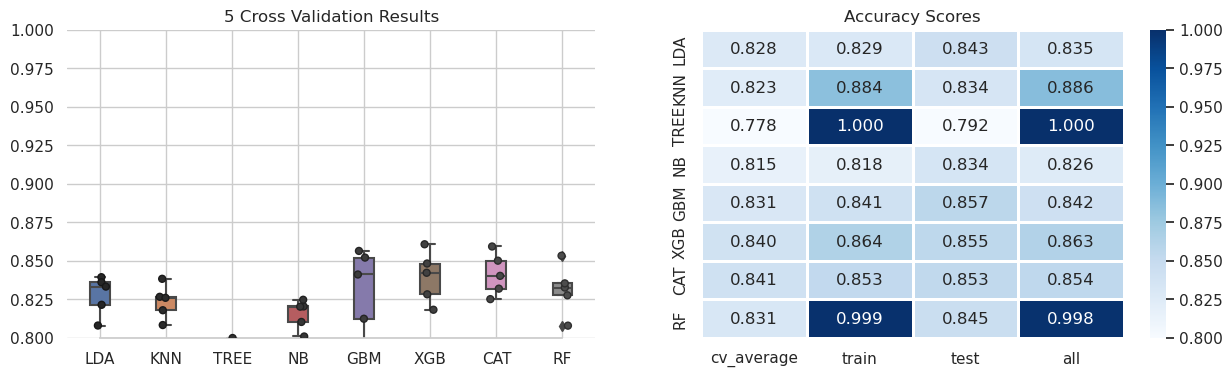

In [37]:
modelEval(df_tr2_ICA_sca0,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

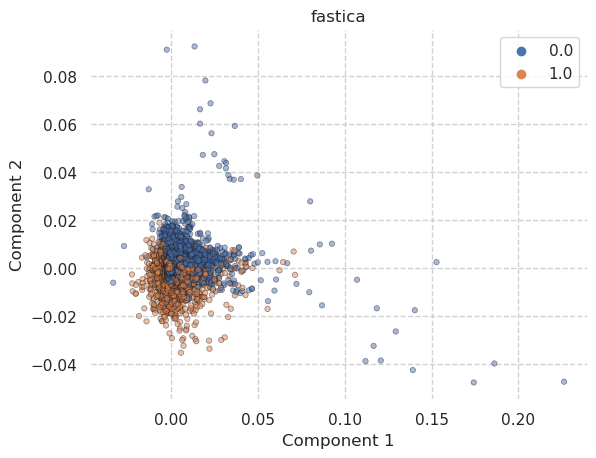

In [38]:
'''RobustScaler ICA'''
df_tr2_ICA_sca1 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,1])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.815(0.015) -> 0.53s | 0.817 & 0.829 -> 0.15s | 0.821 -> 0.16s
KNN : 0.827(0.016) -> 3.03s | 0.883 & 0.831 -> 3.23s | 0.886 -> 3.2s
TREE : 0.778(0.021) -> 2.29s | 1.000 & 0.787 -> 0.63s | 1.000 -> 0.78s
NB : 0.789(0.015) -> 0.09s | 0.790 & 0.806 -> 0.03s | 0.799 -> 0.032s
GBM : 0.823(0.011) -> 13.92s | 0.829 & 0.843 -> 3.58s | 0.833 -> 4.7s
XGB : 0.839(0.016) -> 6.37s | 0.867 & 0.862 -> 1.57s | 0.867 -> 1.9s
CAT : 0.839(0.018) -> 1.11s | 0.852 & 0.858 -> 0.26s | 0.854 -> 0.3s
RF : 0.834(0.017) -> 15.94s | 0.998 & 0.848 -> 4.45s | 0.998 -> 5.7s


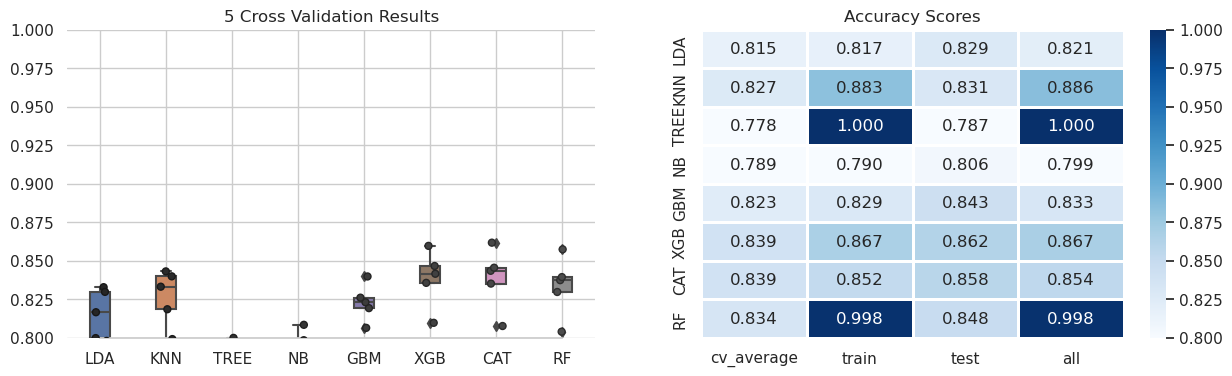

In [39]:
modelEval(df_tr2_ICA_sca1,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

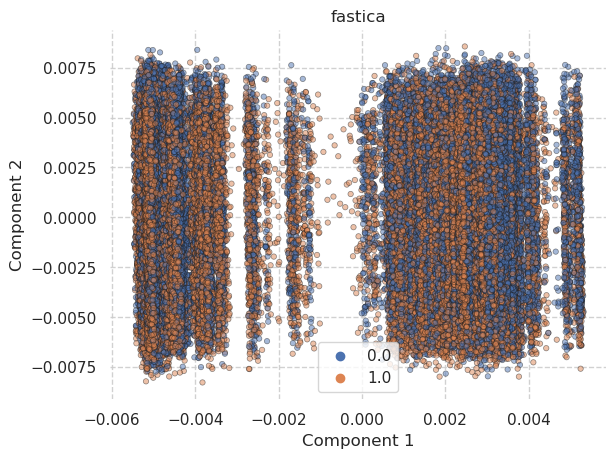

In [40]:
'''MinMaxScaler ICA'''
df_tr2_ICA_sca2 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,2])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.834(0.011) -> 0.53s | 0.835 & 0.859 -> 0.15s | 0.840 -> 0.16s
KNN : 0.812(0.011) -> 2.58s | 0.881 & 0.837 -> 2.90s | 0.883 -> 2.9s
TREE : 0.764(0.019) -> 2.29s | 1.000 & 0.797 -> 0.61s | 1.000 -> 0.77s
NB : 0.825(0.012) -> 0.09s | 0.825 & 0.857 -> 0.03s | 0.829 -> 0.032s
GBM : 0.831(0.011) -> 14.02s | 0.834 & 0.855 -> 3.62s | 0.839 -> 4.6s
XGB : 0.829(0.024) -> 6.13s | 0.858 & 0.861 -> 1.55s | 0.861 -> 1.9s
CAT : 0.834(0.017) -> 1.09s | 0.847 & 0.858 -> 0.27s | 0.850 -> 0.3s
RF : 0.821(0.017) -> 16.47s | 0.998 & 0.851 -> 4.52s | 0.999 -> 5.9s


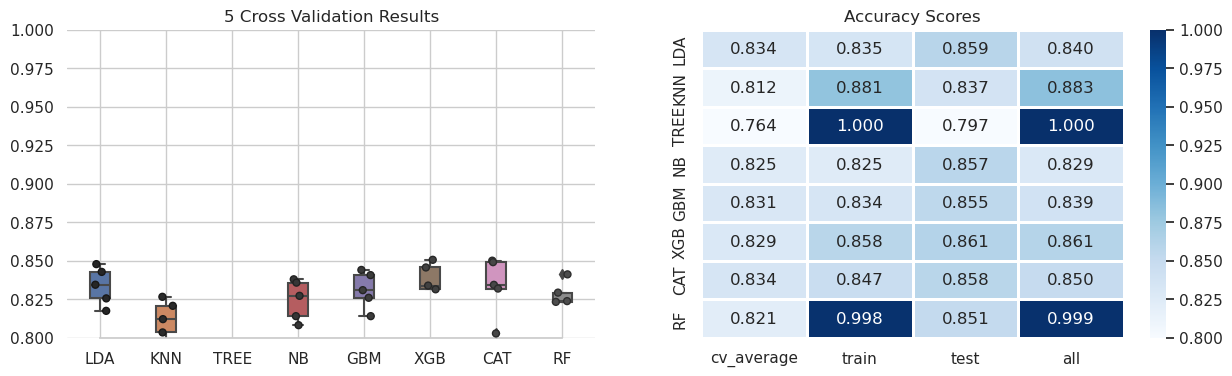

In [41]:
modelEval(df_tr2_ICA_sca2,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

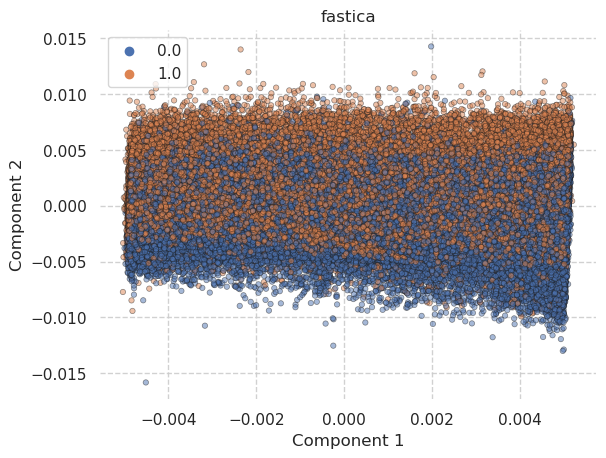

In [42]:
'''Normaliser ICA'''
df_tr2_ICA_sca3 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,3])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.818(0.020) -> 0.54s | 0.821 & 0.846 -> 0.15s | 0.826 -> 0.17s
KNN : 0.799(0.016) -> 2.53s | 0.860 & 0.816 -> 2.80s | 0.863 -> 2.8s
TREE : 0.750(0.020) -> 2.43s | 1.000 & 0.756 -> 0.64s | 1.000 -> 0.83s
NB : 0.793(0.025) -> 0.09s | 0.798 & 0.833 -> 0.03s | 0.804 -> 0.034s
GBM : 0.808(0.015) -> 14.14s | 0.815 & 0.834 -> 3.71s | 0.820 -> 4.7s
XGB : 0.819(0.017) -> 6.41s | 0.838 & 0.845 -> 1.56s | 0.841 -> 1.9s
CAT : 0.820(0.016) -> 1.12s | 0.826 & 0.843 -> 0.27s | 0.830 -> 0.32s
RF : 0.807(0.016) -> 16.72s | 0.998 & 0.833 -> 4.65s | 0.998 -> 6.0s


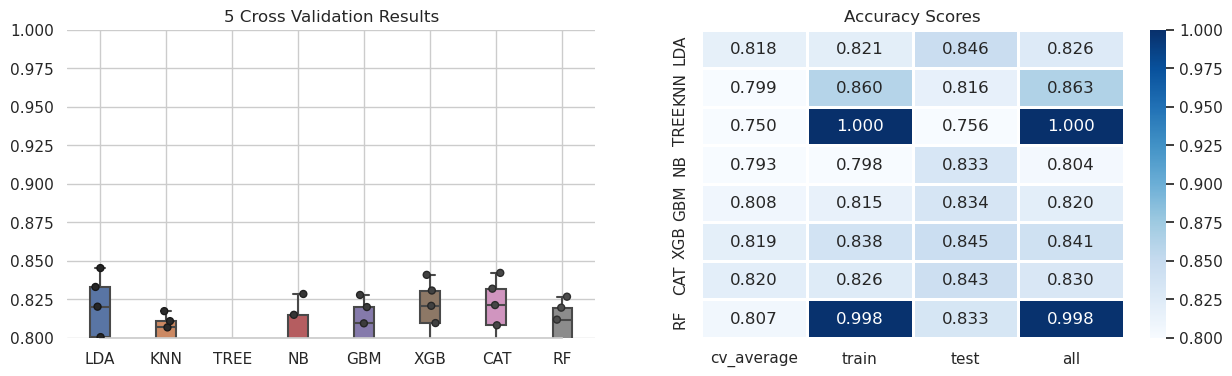

In [43]:
modelEval(df_tr2_ICA_sca3,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])